# Генерация данных

30 тестов. По 10 для 5, 10 и 15 городов

In [20]:
import pandas as pd
import numpy as np

In [21]:
def generate_distance_matrix(num_cities, num_samples=10, max_distance=300):
    distance_matrices = []

    for _ in range(num_samples):
        # Генерация случайных расстояний в диапазоне [5, max_distance] с шагом 5
        distances = np.random.randint(5, max_distance + 1, size=(num_cities, num_cities))

        # Задание кратности 5
        distances = np.ceil(distances / 5) * 5

        # Сделаем матрицу симметричной
        # distances = (distances + distances.T) / 2
        distances = np.tril(distances) + np.tril(distances, -1).T

        # Заполнение главной диагонали бесконечностями, чтобы избежать путешествия из города в самого себя
        np.fill_diagonal(distances, np.inf)

        # Создание DataFrame из массива расстояний
        df_distances = pd.DataFrame(distances, columns=[f'City_{i}' for i in range(1, num_cities + 1)],
                                    index=[f'City_{i}' for i in range(1, num_cities + 1)])

        # Добавляем DataFrame в список
        distance_matrices.append(df_distances)

    return distance_matrices

In [22]:
cities_5 = generate_distance_matrix(5)
cities_10 = generate_distance_matrix(10)
cities_15 = generate_distance_matrix(15)

In [23]:
cities_10[0]

,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10
City_1,inf,110.0,270.0,145.0,190.0,300.0,85.0,260.0,145.0,125.0
City_2,110.0,inf,215.0,65.0,30.0,160.0,35.0,225.0,20.0,240.0
City_3,270.0,215.0,inf,215.0,45.0,100.0,205.0,100.0,140.0,125.0
City_4,145.0,65.0,215.0,inf,50.0,125.0,205.0,140.0,85.0,25.0
City_5,190.0,30.0,45.0,50.0,inf,150.0,205.0,35.0,180.0,130.0
City_6,300.0,160.0,100.0,125.0,150.0,inf,35.0,25.0,105.0,30.0
City_7,85.0,35.0,205.0,205.0,205.0,35.0,inf,280.0,115.0,180.0
City_8,260.0,225.0,100.0,140.0,35.0,25.0,280.0,inf,260.0,85.0
City_9,145.0,20.0,140.0,85.0,180.0,105.0,115.0,260.0,inf,175.0
City_10,125.0,240.0,125.0,25.0,130.0,30.0,180.0,85.0,175.0,inf


# Алгоритмы

## Жадный

In [24]:
def greedy_tsp(distance_matrix):
    num_cities = len(distance_matrix)

    # Выбираем случайный стартовый город
    random_city = np.random.randint(1, num_cities+1)
    current_city = f'City_{random_city}'
    tour = [current_city]
    unvisited_cities = set(distance_matrix.columns)
    unvisited_cities.remove(current_city)

    # Проходим по оставшимся городам
    for _ in range(num_cities - 1):
        next_city = min(unvisited_cities, key=lambda city: distance_matrix[current_city][city])
        tour.append(next_city)
        unvisited_cities.remove(next_city)
        current_city = next_city

    # Возвращаем закольцованный маршрут
    tour.append(tour[0])
    distance = sum(distance_matrix[tour[i]][tour[i + 1]] for i in range(len(tour) - 1))
    return tour, distance

In [25]:
cities_5[0]

,City_1,City_2,City_3,City_4,City_5
City_1,inf,230.0,255.0,175.0,140.0
City_2,230.0,inf,270.0,180.0,270.0
City_3,255.0,270.0,inf,255.0,65.0
City_4,175.0,180.0,255.0,inf,200.0
City_5,140.0,270.0,65.0,200.0,inf


In [26]:
tour, distance = greedy_tsp(cities_5[0])

print("Жадный алгоритм:")
print("Маршрут:", tour)
print("Общее расстояние:", distance)

Жадный алгоритм:
Маршрут: ['City_5', 'City_3', 'City_1', 'City_4', 'City_2', 'City_5']
Общее расстояние: 945.0


# Генетический алгоритм

In [27]:
# Инициализация популяции. Массив случайных маршрутов
def initialize_population(num_individuals, num_cities):
    population = []
    for _ in range(num_individuals):
        route = np.random.permutation(num_cities)
        population.append(route)
    return population

# Считаем длину маршрута
def evaluate_fitness(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix.iloc[route[i], route[i+1]]
    total_distance += distance_matrix.iloc[route[-1], route[0]]  # Вернуться в начальный город
    return total_distance

# Выбираем родителей. Чем меньше расстояние, тем больше вероятность стать родителем.
def select_parents(population, distance_matrix):
    fitness_values = [1 / evaluate_fitness(individual, distance_matrix) for individual in population]
    total_fitness = sum(fitness_values)
    probabilities = [fitness / total_fitness for fitness in fitness_values]
    selected_indices = np.random.choice(len(population), size=2, p=probabilities, replace=False)
    return [population[i] for i in selected_indices]


# Скрещиваем родителей. Их гены передаются потомкам.
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)
    child1 = np.hstack((parent1[:crossover_point], [city for city in parent2 if city not in parent1[:crossover_point]]))
    child2 = np.hstack((parent2[:crossover_point], [city for city in parent1 if city not in parent2[:crossover_point]]))
    return child1, child2

# Мутация потомков. Будет происходить с некторой вероятностью.
def mutate(individual):
    mutation_point1, mutation_point2 = np.random.choice(len(individual), size=2, replace=False)
    individual[mutation_point1], individual[mutation_point2] = individual[mutation_point2], individual[mutation_point1]
    return individual

# Выбираем родителей. Чем меньше расстояние, тем больше вероятность стать родителем.
# def select_parents(population, distance_matrix):
#     fitness_values = [evaluate_fitness(individual, distance_matrix) for individual in population]
#     total_fitness = sum(fitness_values)
#     probabilities = [1 / fitness for fitness in fitness_values]
#     total_prob = sum(probabilities)
#     probabilities_normalized = [prob / total_prob for prob in probabilities]
#     selected_indices = np.random.choice(len(population), size=2, p=probabilities_normalized, replace=False)
#     return [population[i] for i in selected_indices]

In [28]:
def genetic_algorithm(distance_matrix, population_size=20, generations=50, elite_size=2):
    num_cities = len(distance_matrix)
    population = initialize_population(population_size, num_cities)

    for generation in range(generations):
        new_population = []

        # Сохраняем лучших особей (элитизм)
        elites = sorted(population, key=lambda x: evaluate_fitness(x, distance_matrix))[:elite_size]
        new_population.extend(elites)

        for _ in range((population_size - elite_size) // 2):
            parent1, parent2 = select_parents(population, distance_matrix)
            child1, child2 = crossover(parent1, parent2)
            # new_population.extend([child1, child2])
            new_population.extend([mutate(child1), mutate(child2)])

        population = new_population

    best_route = min(population, key=lambda x: evaluate_fitness(x, distance_matrix))
    best_distance = evaluate_fitness(best_route, distance_matrix)

    return best_route, best_distance

In [29]:
tour, distance = genetic_algorithm(cities_10[2])
print("Best Route:", tour)
print("Best Distance:", distance)

Best Route: [3 0 6 4 1 2 7 9 5 8]
Best Distance: 750.0


# Результат

## Точность

Для првоерки точности прогоним каждый алгоритм на одном наборе данных несколько раз. \\
Например 20 раз для 10 городов. \\
считаем, что кто выдает меньший результат, тот и точнее.

In [30]:
df = cities_10[2]

In [31]:
acr_tests = pd.DataFrame({'test': range(1, 21)})
# acr_tests

In [32]:
acr_tests['greedy_dist'] = [greedy_tsp(df)[1] for _ in range(len(acr_tests))]
acr_tests['genetic_dist'] = [genetic_algorithm(df)[1] for _ in range(len(acr_tests))]

In [33]:
acr_tests

,test,greedy_dist,genetic_dist
0,1,835.0,755.0
1,2,835.0,725.0
2,3,795.0,660.0
3,4,1075.0,785.0
4,5,730.0,635.0
5,6,730.0,820.0
6,7,730.0,745.0
7,8,835.0,735.0
8,9,840.0,610.0
9,10,730.0,635.0


In [34]:
# !pip install matplotlib

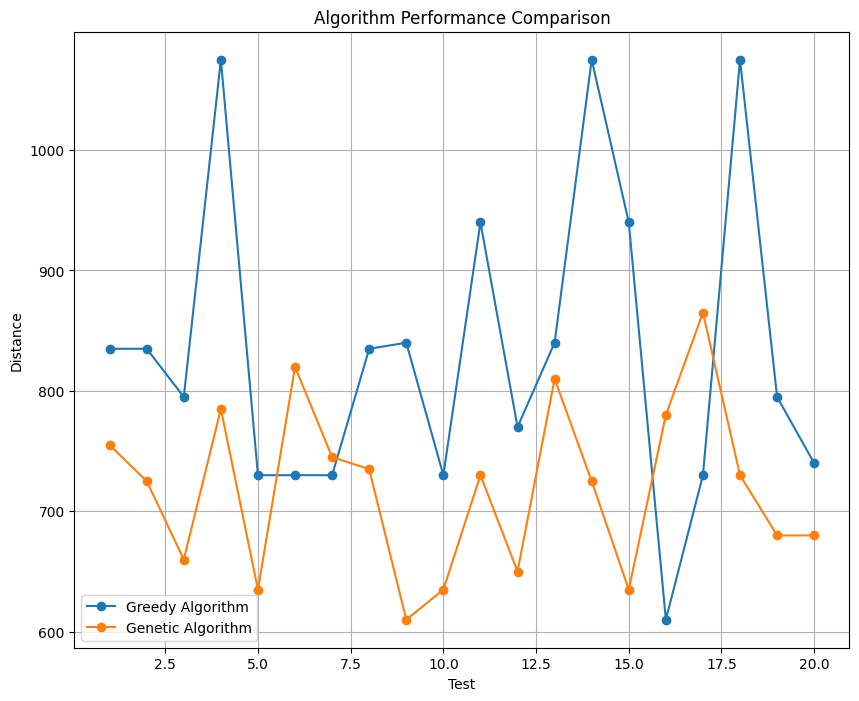

In [35]:
import matplotlib.pyplot as plt

# Построение графика для колонок 'greedy_dist', 'genetic_dist'
plt.figure(figsize=(10, 8))

plt.plot(acr_tests['test'], acr_tests['greedy_dist'], marker='o', label='Greedy Algorithm')
plt.plot(acr_tests['test'], acr_tests['genetic_dist'], marker='o', label='Genetic Algorithm')

plt.title('Algorithm Performance Comparison')
plt.xlabel('Test')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
print(f'Среднее значение Greedy: {acr_tests["greedy_dist"].mean():.2f}')
print(f'Среднее значение Genetic: {acr_tests["genetic_dist"].mean():.2f}')

Среднее значение Greedy: 832.50
Среднее значение Genetic: 719.50


## Время и скорость

In [37]:
import time
import tracemalloc

def get_result(dfs = cities_5, func = greedy_tsp):

  val = []
  time_arr = []
  mem_arr = []

  for df in dfs:
    start_time = time.time()
    tracemalloc.start()
    val.append(func(df)[1])
    req_time = time.time() - start_time
    mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.reset_peak()
    mem_arr.append(mem)
    time_arr.append(req_time)

  return val, time_arr, mem_arr

In [38]:
import pandas as pd

v, t, m = get_result(dfs = cities_5, func = greedy_tsp)
result_df_5 = pd.DataFrame({'Greedy_Dist': v, 'Greedy_Time': t, 'Greedy_Mem': m})

v, t, m = get_result(dfs = cities_5, func = genetic_algorithm)
result_df_5['Genetic_Dist'] = v
result_df_5['Genetic_Time'] = t
result_df_5['Getenic_Mem'] = m

result_df_5

,Greedy_Dist,Greedy_Time,Greedy_Mem,Genetic_Dist,Genetic_Time,Getenic_Mem
0,945.0,0.000758,1975994,830.0,4.761778,1756779
1,555.0,0.003596,1572750,555.0,5.885669,1748461
2,545.0,0.000890,1578961,545.0,4.679829,1757699
3,245.0,0.000841,1585172,245.0,5.245376,1754140
4,390.0,0.000849,1591383,390.0,5.385898,1795526
5,870.0,0.000768,1597690,850.0,4.651556,1793788
6,665.0,0.000746,1604461,490.0,5.920552,1792243
7,670.0,0.000749,1611448,670.0,4.756646,1793392
8,650.0,0.000720,1618579,515.0,4.797059,1796008
9,1010.0,0.001118,1625902,750.0,5.850090,1787120


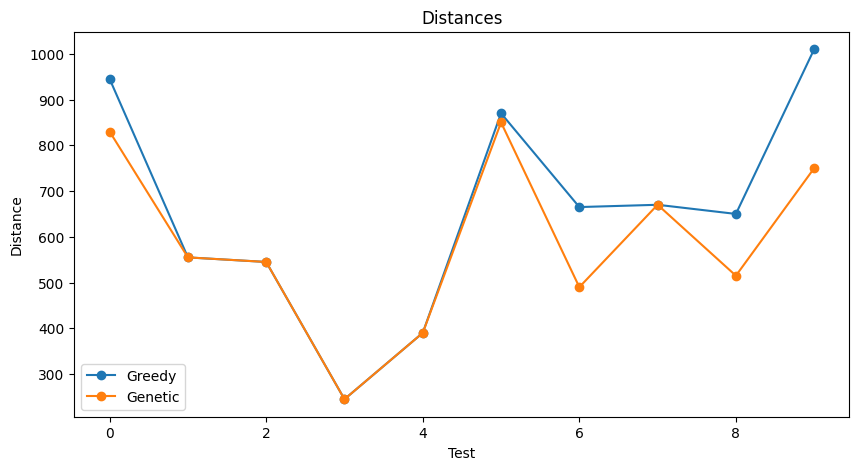

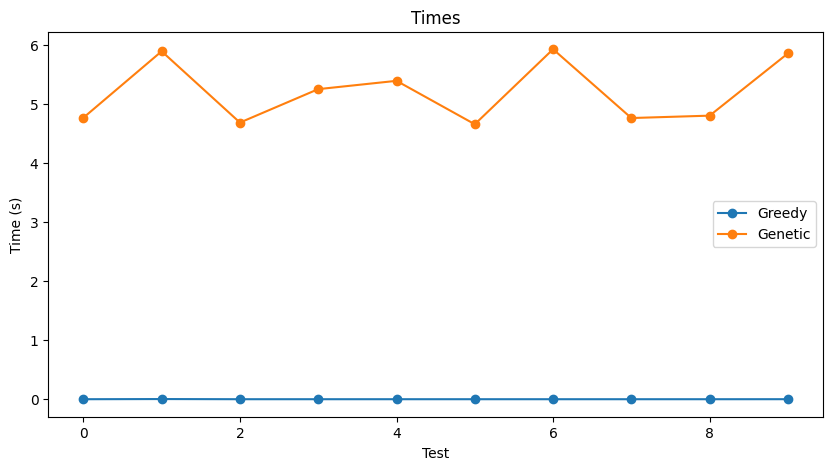

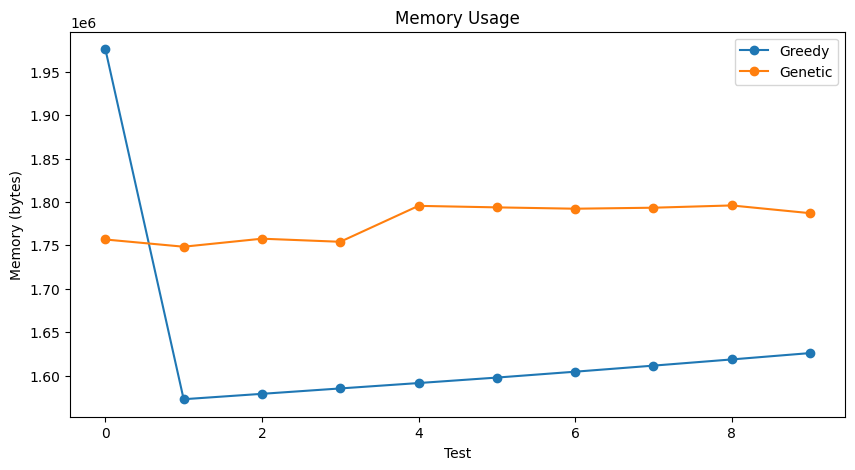

In [40]:
import matplotlib.pyplot as plt

# Данные для графика
distances = result_df_5[['Greedy_Dist', 'Genetic_Dist']]
times = result_df_5[['Greedy_Time', 'Genetic_Time']]
memories = result_df_5[['Greedy_Mem', 'Getenic_Mem']]

# График для расстояния
plt.figure(figsize=(10, 5))
plt.plot(distances, marker='o')
plt.title('Distances')
plt.xlabel('Test')
plt.ylabel('Distance')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для времени
plt.figure(figsize=(10, 5))
plt.plot(times, marker='o')
plt.title('Times')
plt.xlabel('Test')
plt.ylabel('Time (s)')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для памяти
plt.figure(figsize=(10, 5))
plt.plot(memories, marker='o')
plt.title('Memory Usage')
plt.xlabel('Test')
plt.ylabel('Memory (bytes)')
plt.legend(['Greedy', 'Genetic'])
plt.show()


In [41]:
import pandas as pd

v, t, m = get_result(dfs = cities_10, func = greedy_tsp)
result_df_10 = pd.DataFrame({'Greedy_Dist': v, 'Greedy_Time': t, 'Greedy_Mem': m})

v, t, m = get_result(dfs = cities_10, func = genetic_algorithm)
result_df_10['Genetic_Dist'] = v
result_df_10['Genetic_Time'] = t
result_df_10['Getenic_Mem'] = m

result_df_10

,Greedy_Dist,Greedy_Time,Greedy_Mem,Genetic_Dist,Genetic_Time,Getenic_Mem
0,850.0,0.003785,6159534,605.0,11.483334,6227947
1,960.0,0.003000,5982526,885.0,15.933799,6225199
2,740.0,0.000789,5981969,695.0,13.786408,6230345
3,720.0,0.001813,5996053,650.0,15.122417,6233184
4,850.0,0.002076,6010032,695.0,11.899721,6234864
5,755.0,0.002103,6024107,595.0,13.964826,6235485
6,1135.0,0.001725,6038086,940.0,10.775157,6241139
7,810.0,0.001753,6052065,550.0,10.777313,6243679
8,685.0,0.001862,6066044,670.0,10.695106,6252674
9,640.0,0.001793,6081728,620.0,9.622272,6244933


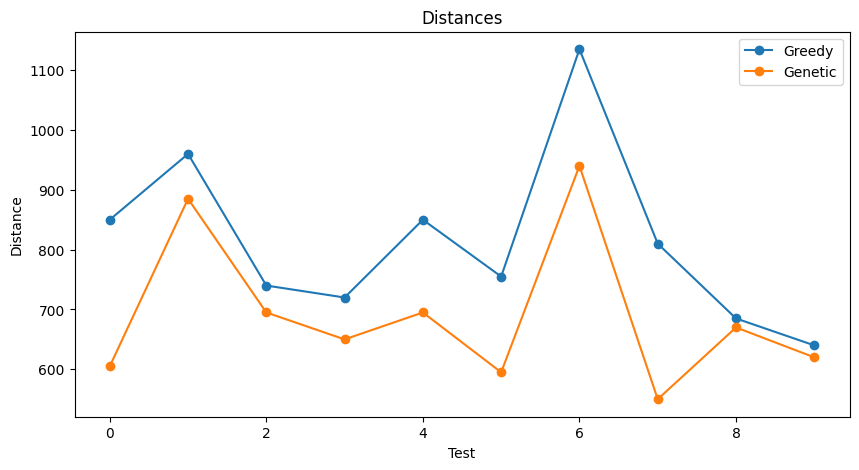

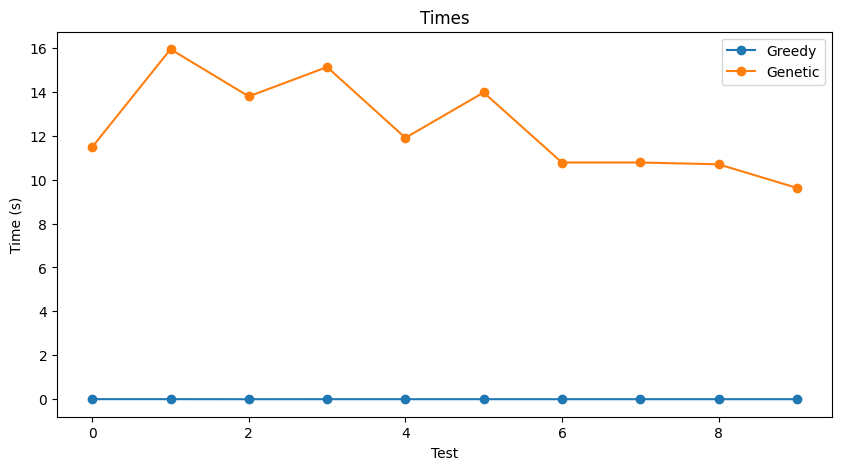

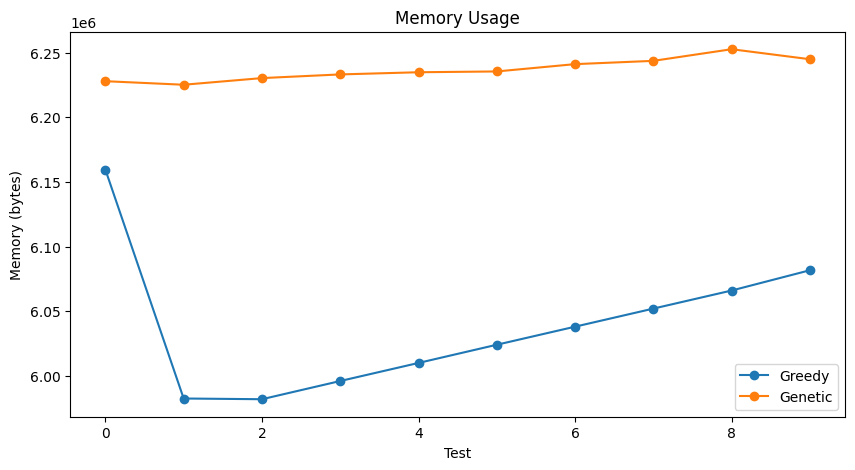

In [42]:
import matplotlib.pyplot as plt

# Данные для графика
distances = result_df_10[['Greedy_Dist', 'Genetic_Dist']]
times = result_df_10[['Greedy_Time', 'Genetic_Time']]
memories = result_df_10[['Greedy_Mem', 'Getenic_Mem']]

# График для расстояния
plt.figure(figsize=(10, 5))
plt.plot(distances, marker='o')
plt.title('Distances')
plt.xlabel('Test')
plt.ylabel('Distance')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для времени
plt.figure(figsize=(10, 5))
plt.plot(times, marker='o')
plt.title('Times')
plt.xlabel('Test')
plt.ylabel('Time (s)')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для памяти
plt.figure(figsize=(10, 5))
plt.plot(memories, marker='o')
plt.title('Memory Usage')
plt.xlabel('Test')
plt.ylabel('Memory (bytes)')
plt.legend(['Greedy', 'Genetic'])
plt.show()


In [43]:
import pandas as pd

v, t, m = get_result(dfs = cities_15, func = greedy_tsp)
result_df_15 = pd.DataFrame({'Greedy_Dist': v, 'Greedy_Time': t, 'Greedy_Mem': m})

v, t, m = get_result(dfs = cities_15, func = genetic_algorithm)
result_df_15['Genetic_Dist'] = v
result_df_15['Genetic_Time'] = t
result_df_15['Getenic_Mem'] = m

result_df_15

,Greedy_Dist,Greedy_Time,Greedy_Mem,Genetic_Dist,Genetic_Time,Getenic_Mem
0,805.0,0.007730,8073429,1055.0,14.918483,8304665
1,850.0,0.004609,7947517,910.0,15.393830,8310699
2,585.0,0.003951,7969928,1055.0,15.371230,8315067
3,820.0,0.003004,7990820,1150.0,14.733456,8318555
4,715.0,0.003309,8012154,1300.0,15.127001,8319571
5,835.0,0.003082,8035325,1040.0,14.845966,8321868
6,895.0,0.003474,8059379,865.0,14.820009,8329683
7,1000.0,0.003293,8083570,1215.0,15.079564,8331700
8,1170.0,0.002888,8106982,1170.0,14.960323,8411699
9,815.0,0.003560,8132514,1100.0,16.895312,8411610


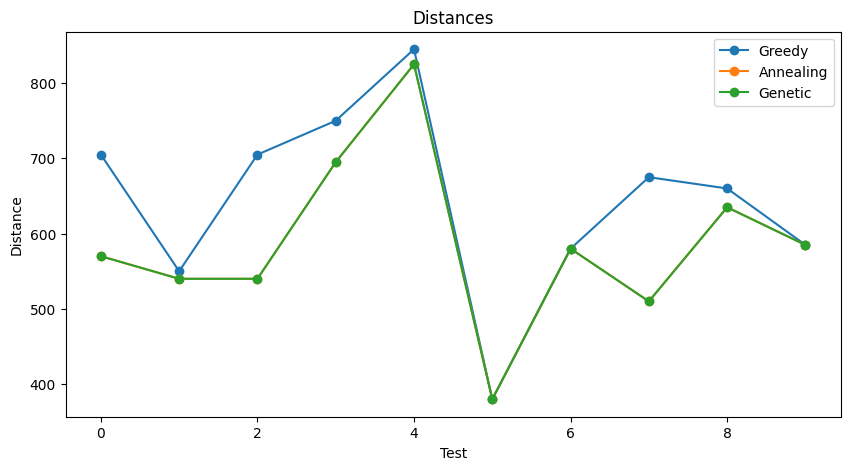

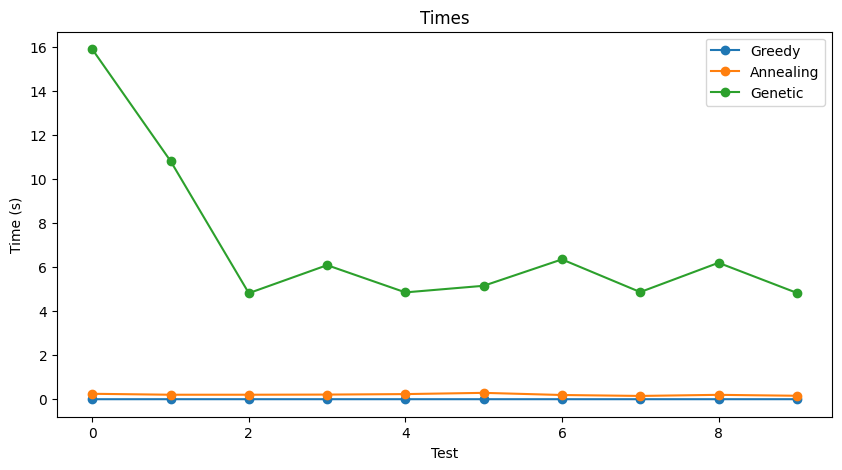

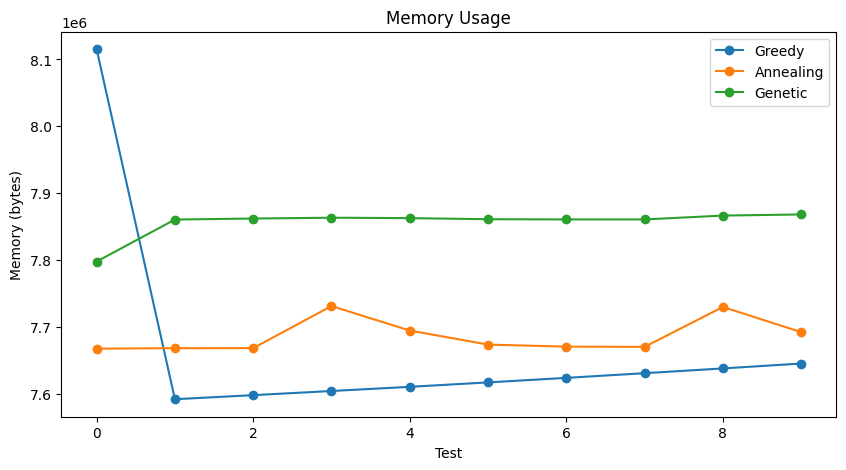

In [ ]:
import matplotlib.pyplot as plt

# Данные для графика
distances = result_df_5[['Greedy_Dist', 'Genetic_Dist']]
times = result_df_5[['Greedy_Time', 'Genetic_Time']]
memories = result_df_5[['Greedy_Mem', 'Getenic_Mem']]

# График для расстояния
plt.figure(figsize=(10, 5))
plt.plot(distances, marker='o')
plt.title('Distances')
plt.xlabel('Test')
plt.ylabel('Distance')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для времени
plt.figure(figsize=(10, 5))
plt.plot(times, marker='o')
plt.title('Times')
plt.xlabel('Test')
plt.ylabel('Time (s)')
plt.legend(['Greedy', 'Genetic'])
plt.show()

# График для памяти
plt.figure(figsize=(10, 5))
plt.plot(memories, marker='o')
plt.title('Memory Usage')
plt.xlabel('Test')
plt.ylabel('Memory (bytes)')
plt.legend(['Greedy', 'Annealing', 'Genetic'])
plt.show()
